In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
mydir = 'data_dir/raw_data/'
os.listdir(mydir)

['holidays_events.csv',
 'oil.csv',
 'preprocessed_train_data.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [3]:
train = pd.read_csv(mydir + 'train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_data = train.groupby(['date','store_nbr']).sales.sum().reset_index()
train_data.head()

,date,store_nbr,sales
0,2013-01-01,1,0.0
1,2013-01-01,2,0.0
2,2013-01-01,3,0.0
3,2013-01-01,4,0.0
4,2013-01-01,5,0.0


In [5]:
stores_df   = pd.read_csv(mydir+'stores.csv')    
stores_df   = stores_df.drop_duplicates()
stores_df   = stores_df.dropna()
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
train_data = pd.merge(train_data, stores_df, on = 'store_nbr', how= 'left')

In [7]:
city_state_map = stores_df[['state','city']].drop_duplicates()
city_state_map.sort_values('state')

,state,city
36,Azuay,Cuenca
18,Bolivar,Guaranda
13,Chimborazo,Riobamba
11,Cotopaxi,Latacunga
39,El Oro,Machala
42,Esmeraldas,Esmeraldas
34,Guayas,Playas
35,Guayas,Libertad
23,Guayas,Guayaquil
26,Guayas,Daule


In [8]:
he_df   = pd.read_csv(mydir+'holidays_events.csv')   
he_df   = he_df[he_df['transferred']==False] #elimination the transferred holidays
he_df['city']  = he_df.apply(lambda row: row['locale_name'] if row['locale'].lower() == 'local' else 'NA', axis=1)
he_df['state'] = he_df.apply(lambda row: row['locale_name'] if row['locale'].lower() == 'regional' else 'NA', axis=1)
he_df['state_mapped'] = pd.merge(he_df['city'],city_state_map,on = 'city', how = 'left')['state']
he_df['state'] = he_df.apply(lambda row: row['state_mapped'] if row['state'].lower() == 'na' else row['state'], axis=1)
he_df = he_df.drop(columns = ['state_mapped'])
he_df = he_df.rename(columns = {'type':'holiday_type'})
he_df.head()

,date,holiday_type,locale,locale_name,description,transferred,city,state
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,Manta,Manabi
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,NA,Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,Cuenca,Azuay
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,Libertad,Guayas
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,Riobamba,Chimborazo


In [9]:
#Divide the he_df with types of locale = national

he_df_national  = he_df.loc[he_df['locale'] == 'National',['date','holiday_type']]
he_df_national  = he_df_national.rename(columns = {'holiday_type' : 'holiday_type_national' })
he_df_national['IS_NATIONAL_HOLIDAY'] = 1
he_df_national

,date,holiday_type_national,IS_NATIONAL_HOLIDAY
14,2012-08-10,Holiday,1
20,2012-10-12,Transfer,1
21,2012-11-02,Holiday,1
22,2012-11-03,Holiday,1
31,2012-12-21,Additional,1
...,...,...,...
345,2017-12-22,Additional,1
346,2017-12-23,Additional,1
347,2017-12-24,Additional,1
348,2017-12-25,Holiday,1


In [10]:
train_data = pd.merge(train_data, he_df_national, on = 'date', how= 'left')

In [11]:
#Divide the he_df with types of locale = regional

he_df_regional  = he_df.loc[he_df['locale'] == 'Regional',['date','state','holiday_type']]
he_df_regional  = he_df_regional.rename(columns = {'holiday_type' : 'holiday_type_state' })
he_df_regional['IS_REGIONAL_HOLIDAY'] = 1
he_df_regional

,date,state,holiday_type_state,IS_REGIONAL_HOLIDAY
1,2012-04-01,Cotopaxi,Holiday,1
7,2012-06-25,Imbabura,Holiday,1
23,2012-11-06,Santo Domingo de los Tsachilas,Holiday,1
24,2012-11-07,Santa Elena,Holiday,1
47,2013-04-01,Cotopaxi,Holiday,1
58,2013-06-25,Imbabura,Holiday,1
76,2013-11-06,Santo Domingo de los Tsachilas,Holiday,1
77,2013-11-07,Santa Elena,Holiday,1
96,2014-04-01,Cotopaxi,Holiday,1
112,2014-06-25,Imbabura,Holiday,1


In [12]:
train_data = pd.merge(train_data, he_df_regional, on = ['date','state'], how= 'left')

In [13]:
#Divide the he_df with types of locale = local

he_df_local  = he_df.loc[he_df['locale'] == 'Local',['date','city','holiday_type']]
he_df_local  = he_df_local.rename(columns = {'holiday_type' : 'holiday_type_city' })
he_df_local['IS_LOCAL_HOLIDAY'] = 1
he_df_local

,date,city,holiday_type_city,IS_LOCAL_HOLIDAY
0,2012-03-02,Manta,Holiday,1
2,2012-04-12,Cuenca,Holiday,1
3,2012-04-14,Libertad,Holiday,1
4,2012-04-21,Riobamba,Holiday,1
5,2012-05-12,Puyo,Holiday,1
...,...,...,...,...
338,2017-11-12,Ambato,Holiday,1
339,2017-12-05,Quito,Additional,1
341,2017-12-08,Loja,Holiday,1
342,2017-12-08,Quito,Transfer,1


In [14]:
train_data = pd.merge(train_data, he_df_local, on = ['date','city'], how= 'left')


In [15]:
train_data['holiday_type'] = train_data['holiday_type_city'].fillna(train_data['holiday_type_state']).fillna(train_data['holiday_type_national'])
train_data=train_data.drop(columns = ['holiday_type_city','holiday_type_state','holiday_type_national'])
train_data.head()

,date,store_nbr,sales,city,state,type,cluster,IS_NATIONAL_HOLIDAY,IS_REGIONAL_HOLIDAY,IS_LOCAL_HOLIDAY,holiday_type
0,2013-01-01,1,0.0,Quito,Pichincha,D,13,1.0,NaN,NaN,Holiday
1,2013-01-01,2,0.0,Quito,Pichincha,D,13,1.0,NaN,NaN,Holiday
2,2013-01-01,3,0.0,Quito,Pichincha,D,8,1.0,NaN,NaN,Holiday
3,2013-01-01,4,0.0,Quito,Pichincha,D,9,1.0,NaN,NaN,Holiday
4,2013-01-01,5,0.0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,1.0,NaN,NaN,Holiday


In [16]:
train_data['IS_NATIONAL_HOLIDAY'] = train_data['IS_NATIONAL_HOLIDAY'].fillna(0)
train_data['IS_REGIONAL_HOLIDAY'] = train_data['IS_REGIONAL_HOLIDAY'].fillna(0)
train_data['IS_LOCAL_HOLIDAY'] = train_data['IS_LOCAL_HOLIDAY'].fillna(0)
train_data['IS_HOLIDAY'] = train_data['IS_LOCAL_HOLIDAY'] + train_data['IS_REGIONAL_HOLIDAY'] + train_data['IS_NATIONAL_HOLIDAY']
train_data['IS_HOLIDAY'] = np.clip(train_data['IS_HOLIDAY'], 0, 1)
train_data  = train_data.drop(columns = ['IS_NATIONAL_HOLIDAY','IS_REGIONAL_HOLIDAY','IS_LOCAL_HOLIDAY'])

In [17]:
oil_df  = pd.read_csv(mydir +'oil.csv')
oil_df  = oil_df.drop_duplicates()
oil_df  = oil_df.dropna(subset = 'dcoilwtico')
oil_df.head()

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21


In [18]:
train_data = pd.merge(train_data, oil_df, on = 'date', how= 'left')

In [19]:
train_data.head()

,date,store_nbr,sales,city,state,type,cluster,holiday_type,IS_HOLIDAY,dcoilwtico
0,2013-01-01,1,0.0,Quito,Pichincha,D,13,Holiday,1.0,NaN
1,2013-01-01,2,0.0,Quito,Pichincha,D,13,Holiday,1.0,NaN
2,2013-01-01,3,0.0,Quito,Pichincha,D,8,Holiday,1.0,NaN
3,2013-01-01,4,0.0,Quito,Pichincha,D,9,Holiday,1.0,NaN
4,2013-01-01,5,0.0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Holiday,1.0,NaN


In [20]:
txn_df  = pd.read_csv(mydir+ 'transactions.csv')
txn_df  = txn_df.drop_duplicates()
txn_df  = txn_df.dropna()
txn_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [21]:
train_data = pd.merge(train_data, txn_df, on=['date','store_nbr'],how='left')

In [22]:
train_data.head()

,date,store_nbr,sales,city,state,type,cluster,holiday_type,IS_HOLIDAY,dcoilwtico,transactions
0,2013-01-01,1,0.0,Quito,Pichincha,D,13,Holiday,1.0,NaN,NaN
1,2013-01-01,2,0.0,Quito,Pichincha,D,13,Holiday,1.0,NaN,NaN
2,2013-01-01,3,0.0,Quito,Pichincha,D,8,Holiday,1.0,NaN,NaN
3,2013-01-01,4,0.0,Quito,Pichincha,D,9,Holiday,1.0,NaN,NaN
4,2013-01-01,5,0.0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Holiday,1.0,NaN,NaN


In [23]:
train_data['IS_HOLIDAY'].unique()

array([1., 0.])

<Axes: xlabel='sales', ylabel='transactions'>

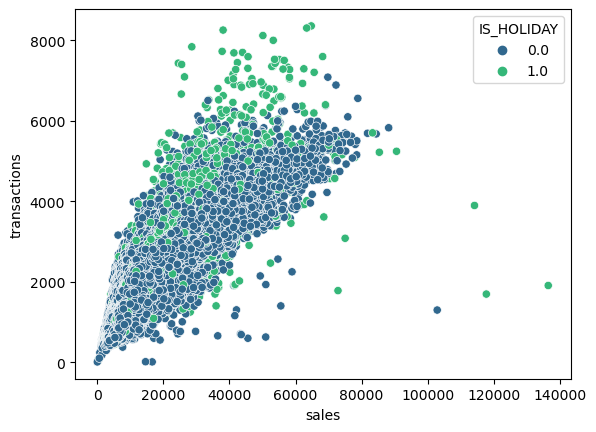

In [24]:
sns.scatterplot(data=train_data, x='sales', y='transactions', hue='IS_HOLIDAY', palette='viridis')

In [25]:
train_data_v2 = train_data.drop(columns = ['sales','transactions']) #dropping transaction data
train_data_v2 = train_data_v2.rename(columns = {'dcoilwtico':'oil_price'})

In [26]:
train = pd.merge(train, train_data_v2, on = ['date', 'store_nbr'], how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_type,IS_HOLIDAY,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,1.0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,Holiday,1.0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,1.0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,Holiday,1.0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,Holiday,1.0,NaN


In [27]:
train.to_csv('data_dir/wip_data/preprocessed_train_data.csv')